In [76]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from transformers import get_linear_schedule_with_warmup
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from pymorphy2 import MorphAnalyzer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
#from gensim.models import Word2Vec

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from torch.optim import AdamW
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt
from google.colab import files
import collections
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt



In [77]:
uploaded = files.upload()

In [78]:
!unzip dl-2025-study-competition-2.zip

Archive:  dl-2025-study-competition-2.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [79]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [80]:
df

,id,text,labels
0,0,15 января\nДетская развлекательная программа\n...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1
1,1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
2,2,Йокнапатофа\nПостановка Театр им. Маяковского\...,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1
3,3,Впервые в Уфе танцевальная терапия в группе с ...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0
4,4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0
...,...,...,...
29563,29563,Выступление Симфо-группы TEODOR\n⠀\n22 июля в ...,0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 0
29564,29564,"🔤\nЮЗИКЛ ""МОНТЕ-КРИСТО"" ТЕАТР ОПЕРЕТТЫ\nЭто оч...",1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0
29565,29565,РАСПИСАНИЕ БЕСПЛАТНЫХ ЭКСКУРСИЙ\nв октябре 202...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0
29566,29566,Долгожданный концерт Надежды Кадышевой в Рязан...,1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 1 1 0


In [81]:
df['labels_list'] = df.labels.apply(lambda x: list(map(int, x.strip().split())))
n_class = len(df.labels_list.iloc[0])
print(f'Количество классов: {n_class}')

Количество классов: 20



Распределение классов:
Класс 0: 15582 примеров
Класс 1: 18979 примеров
Класс 2: 1490 примеров
Класс 3: 1776 примеров
Класс 4: 17812 примеров
Класс 5: 99 примеров
Класс 6: 206 примеров
Класс 7: 22555 примеров
Класс 8: 23344 примеров
Класс 9: 20497 примеров
Класс 10: 12811 примеров
Класс 11: 18510 примеров
Класс 12: 23071 примеров
Класс 13: 22997 примеров
Класс 14: 22296 примеров
Класс 15: 14925 примеров
Класс 16: 21933 примеров
Класс 17: 23523 примеров
Класс 18: 24300 примеров
Класс 19: 5765 примеров


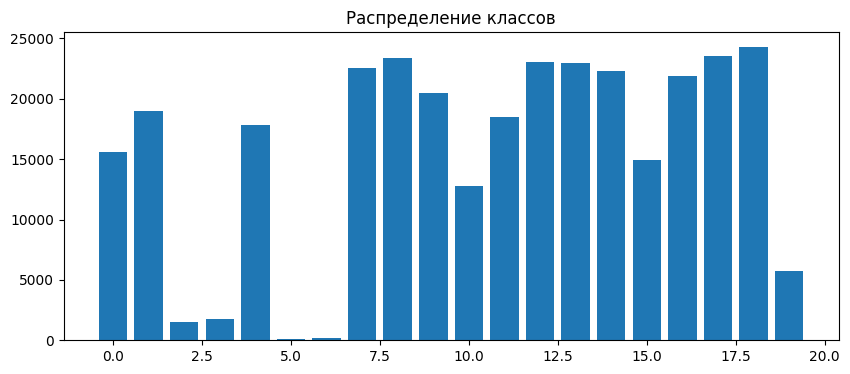

In [8]:
labels = np.array([list(map(int, row.split())) for row in df['labels']])
class_counts = labels.sum(axis=0)

print("\nРаспределение классов:")
for i, count in enumerate(class_counts):
    print(f"Класс {i}: {count} примеров")

plt.figure(figsize=(10, 4))
plt.bar(range(len(class_counts)), class_counts)
plt.title("Распределение классов")
plt.show()

На графике четко виден сильный перекос в данных - одни метки встречаются очень часто, другие крайне редко. Например:


* Классы 4, 7, 8, 13, 18 и 19 доминируют - у каждого больше 20 тысяч примеров
*  Классы 2, 3, 5 и 6 аутсайдеры с менее 5 тысячами примеров
*  Особенно страдают классы 5, 6 - их примеров катастрофически мало


In [82]:
# Пример текста с максимальной длиной
print("\nСамый длинный текст:")
print(df.loc[df['text'].idxmax(), 'text'])


Самый длинный текст:
🫶
16 СЕНТЯБРЯ
🫶
•Ecstatic Dance в Небесном Особняке•
🔥
Ecstatic Dance – это дающий поистине мощный заряд энергии танцевально-музыкальный опыт, сравнимый с естественной эйфорией. Раскрепощение, бережный выплеск эмоций и наслаждение в одном флаконе.
В ПРОГРАММЕ ТЕБЯ ЖДЕТ:
🏠
Огромное пространство особняка и природа
🌿
Семь топовых мастеров
🎧
Медитативный музыкальный сет от «Andre Mayborn»
🌱
Какао церемония с проводником «Ириной Кособукиной»
🌌
Sound Healing с хрустальными чашами от «Леоры»
🫖
Чайная церемония на сеновале
🔥
Две уникальных бани на дровах которые проведет сам владелец пространства
🍀
Медитация и тантра практика
💃
Комьюнити красивых людей
МЕСТО: Небесный Особняк / 14 км от МКАД
ДАТА: 16.09 (Суббота)
СТАРТ: 15:00
Обещаем, будет жарко
🔥
Такое, ты точно не испытывал
🤗
Подробности в директ или по номеру телефона +7 923 577 4488
Telegram
@valero44444ka
Валерия
https://t.me/skill_new_time
Чудесного дня
✨


In [83]:
#эмоджи
print(df['text'].str.contains(r'[:;=]-?[\)\(DP]').sum())

79


In [84]:
duplicates = df[df["text"].duplicated(keep=False)]
duplicates

,id,text,labels,labels_list
10,10,С праздником! В этот день желаем вам только ми...,1 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1,"[1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, ..."
11,11,Органный концерт «Бах и рыцари органа»\n🏛\nСоб...,1 1 0 0 1 0 0 1 1 1 0 0 1 1 1 0 1 1 1 0,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, ..."
14,14,"""Ромео и Джульетта"" : нарисованный театр\n🏛\nТ...",0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ..."
18,18,Концерт группы «Аттракцион Воронова»\nТрадицио...,1 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 0 1 0,"[1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, ..."
21,21,"Комедия ""Последний шанс""\n🏛\nРусская песня\n🗓\...",0 1 0 0 0 0 0 1 1 1 1 1 0 1 1 0 0 1 1 0,"[0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, ..."
...,...,...,...,...
29529,29529,#афиша #афиша_москвы #мероприятия #выставки #ф...,0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 1,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ..."
29534,29534,Смешной и остроумный спектакль «Свадебный Сезо...,0 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0,"[0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, ..."
29542,29542,Концерт группы «Аттракцион Воронова»\nКогда: 9...,0 1 0 0 1 0 0 1 1 0 0 0 1 1 1 1 1 0 0 1,"[0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, ..."
29551,29551,-25% на концерт «Диско на крыше с симфонически...,0 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0,"[0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, ..."


In [85]:
#df = df.drop_duplicates(subset=["text"], keep=False)
df

,id,text,labels,labels_list
0,0,15 января\nДетская развлекательная программа\n...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1,"[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, ..."
1,1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1,"[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, ..."
2,2,Йокнапатофа\nПостановка Театр им. Маяковского\...,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ..."
3,3,Впервые в Уфе танцевальная терапия в группе с ...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0,"[1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, ..."
...,...,...,...,...
29563,29563,Выступление Симфо-группы TEODOR\n⠀\n22 июля в ...,0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 0,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, ..."
29564,29564,"🔤\nЮЗИКЛ ""МОНТЕ-КРИСТО"" ТЕАТР ОПЕРЕТТЫ\nЭто оч...",1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0,"[1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, ..."
29565,29565,РАСПИСАНИЕ БЕСПЛАТНЫХ ЭКСКУРСИЙ\nв октябре 202...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ..."
29566,29566,Долгожданный концерт Надежды Кадышевой в Рязан...,1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 1 1 0,"[1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, ..."


## Очистка

In [86]:
import inspect
def getargspec(func):
    """Реализация getargspec для новых версий Python"""
    sig = inspect.signature(func)
    args = []
    varargs = None
    varkw = None
    defaults = []

    for param in sig.parameters.values():
        if param.kind == param.VAR_POSITIONAL:
            varargs = param.name
        elif param.kind == param.VAR_KEYWORD:
            varkw = param.name
        else:
            args.append(param.name)
            if param.default is not param.empty:
                defaults.append(param.default)

    return collections.namedtuple('ArgSpec', 'args varargs keywords defaults')(
        args, varargs, varkw, tuple(defaults) if defaults else None)

if not hasattr(inspect, 'getargspec'):
    inspect.getargspec = getargspec

In [87]:
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))
morph = MorphAnalyzer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [88]:
def clean_text_tfidf(text):
    text = text.lower()
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'[^а-яё\s]', '', text)
    words = text.split()
    words = [morph.parse(w)[0].normal_form for w in words if w not in stop_words]
    return ' '.join(words)

In [89]:
def clean_text_w2v(text):
    text = text.lower()
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'[^а-яё\s]', '', text)
    words = text.split()
    words = [morph.parse(w)[0].normal_form for w in words]
    return ' '.join(words)

In [ ]:
df['clean_tfidf'] = df.text.apply(clean_text_tfidf)
df['clean_w2v'] = df.text.apply(clean_text_w2v)



#  tf-idf + любая нейронная сеть

In [ ]:
X = df['clean_tfidf'].tolist()
y = np.array(list(df['labels_list']), dtype=np.float32)



In [ ]:
tfidf = TfidfVectorizer(max_features=10000)
X_tfidf = tfidf.fit_transform(X)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42)

In [ ]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return (
            torch.FloatTensor(self.X[idx].toarray().squeeze()),
            torch.FloatTensor(self.y[idx])
        )

train_loader = DataLoader(TextDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TextDataset(X_val, y_val), batch_size=64)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

model = MLP(X_train.shape[1], y_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate(model, loader, criterion, threshold=0.5):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch)
            all_preds.append(outputs.numpy())
            all_labels.append(y_batch.numpy())

    preds = (np.concatenate(all_preds) > threshold).astype(int)
    labels = np.concatenate(all_labels)
    return f1_score(labels, preds, average='micro')


In [26]:
epochs = 20
train_losses = []
val_scores = []

for epoch in range(epochs):
    loss = train_epoch(model, train_loader, optimizer, criterion)
    score = validate(model, val_loader, criterion)

    train_losses.append(loss)
    val_scores.append(score)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {loss:.4f} | Val F1: {score:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

KeyboardInterrupt: 

In [27]:

df_test = pd.read_csv('test.csv')
df_test['clean_tfidf'] = df_test['text'].apply(clean_text_tfidf)
X_test_tfidf = tfidf.transform(df_test['clean_tfidf'])
X_test_tensor = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)

In [28]:
model.eval()

with torch.no_grad():
    preds_proba = model(X_test_tensor).cpu().numpy()

threshold = 0.5
y_test_pred = (preds_proba > threshold).astype(int)

Примеры предсказаний:


In [29]:
ids = list(range(29568, 29568 + len(df_test)))

labels_str = [' '.join(map(str, row)) for row in y_test_pred]

final_dataframe = pd.DataFrame({
    'id': ids,
    'labels': labels_str
}).set_index('id')

final_dataframe.to_csv('predictions.csv', index=True)
print("Результаты сохранены в predictions.csv")

Результаты сохранены в predictions.csv


Результат: 0.83794

##  w2v + любая нейронная сеть;

In [30]:
train_tokens = list(df['clean_w2v'])

w2v_model = Word2Vec(
    sentences=train_tokens,
    vector_size=300,
    window=5,
    min_count=2,
    workers=4,
    epochs=10
)

In [31]:
def tokenize_text(text):
    return text.split()

df['tokens'] = df['clean_w2v'].apply(tokenize_text)
train_tokens = df['tokens'].tolist()
y = np.array(df['labels_list'].tolist(), dtype=np.float32)

In [32]:
def text_to_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    return np.zeros(model.vector_size)

X = np.array([text_to_vector(tokens, w2v_model) for tokens in train_tokens])


In [33]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y.argmax(axis=1), random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
368/370 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0492 - auc: 0.6665 - loss: 0.7283

370/370 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.0492 - auc: 0.6669 - loss: 0.7277 - val_accuracy: 0.0100 - val_auc: 0.8645 - val_loss: 0.4925 - learning_rate: 2.0000e-04
Epoch 2/20
368/370 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0217 - auc: 0.8419 - loss: 0.5056

370/370 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.0216 - auc: 0.8421 - loss: 0.5053 - val_accuracy: 0.0019 - val_auc: 0.9044 - val_loss: 0.3850 - learning_rate: 4.0000e-04
Epoch 3/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0063 - auc: 0.8921 - loss: 0.4096

370/370 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.0063 - auc: 0.8921 - loss: 0.4096 - val_accuracy: 0.0073 - val_auc: 0.9087 - val_loss: 0.3743 - learning_rate: 6.0000e-04
Epoch 4/20
367/370 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0058 - auc: 0.9001 - loss: 0.3919

370/370 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.0058 - auc: 0.9002 - loss: 0.3918 - val_accuracy: 0.0068 - val_auc: 0.9099 - val_loss: 0.3713 - learning_rate: 8.0000e-04
Epoch 5/20
367/370 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0066 - auc: 0.9034 - loss: 0.3841

370/370 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.0066 - auc: 0.9034 - loss: 0.3840 - val_accuracy: 0.0066 - val_auc: 0.9118 - val_loss: 0.3670 - learning_rate: 0.0010
Epoch 6/20
366/370 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0066 - auc: 0.9062 - loss: 0.3777

370/370 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.0066 - auc: 0.9062 - loss: 0.3777 - val_accuracy: 0.0071 - val_auc: 0.9121 - val_loss: 0.3657 - learning_rate: 0.0010
Epoch 7/20
366/370 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0071 - auc: 0.9075 - loss: 0.3749

370/370 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.0071 - auc: 0.9075 - loss: 0.3748 - val_accuracy: 0.0076 - val_auc: 0.9124 - val_loss: 0.3650 - learning_rate: 9.0000e-04
Epoch 8/20
369/370 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0079 - auc: 0.9096 - loss: 0.3712

370/370 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.0079 - auc: 0.9096 - loss: 0.3712 - val_accuracy: 0.0132 - val_auc: 0.9137 - val_loss: 0.3628 - learning_rate: 8.1000e-04
Epoch 9/20
368/370 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0082 - auc: 0.9117 - loss: 0.3663

370/370 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.0082 - auc: 0.9117 - loss: 0.3664 - val_accuracy: 0.0137 - val_auc: 0.9137 - val_loss: 0.3626 - learning_rate: 7.2900e-04
Epoch 10/20
368/370 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0081 - auc: 0.9115 - loss: 0.3666

370/370 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.0081 - auc: 0.9115 - loss: 0.3666 - val_accuracy: 0.0081 - val_auc: 0.9142 - val_loss: 0.3614 - learning_rate: 6.5610e-04
Epoch 11/20
366/370 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0082 - auc: 0.9127 - loss: 0.3647

370/370 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.0082 - auc: 0.9127 - loss: 0.3648 - val_accuracy: 0.0085 - val_auc: 0.9149 - val_loss: 0.3602 - learning_rate: 5.9049e-04
Epoch 12/20
366/370 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0079 - auc: 0.9128 - loss: 0.3645

370/370 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.0079 - auc: 0.9128 - loss: 0.3645 - val_accuracy: 0.0022 - val_auc: 0.9153 - val_loss: 0.3591 - learning_rate: 5.3144e-04
Epoch 13/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.0078 - auc: 0.9136 - loss: 0.3630 - val_accuracy: 0.0135 - val_auc: 0.9153 - val_loss: 0.3590 - learning_rate: 4.7830e-04
Epoch 14/20
369/370 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0076 - auc: 0.9142 - loss: 0.3618

370/370 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.0076 - auc: 0.9142 - loss: 0.3618 - val_accuracy: 0.0137 - val_auc: 0.9156 - val_loss: 0.3583 - learning_rate: 4.3047e-04
Epoch 15/20
367/370 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0093 - auc: 0.9147 - loss: 0.3610

370/370 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.0093 - auc: 0.9147 - loss: 0.3610 - val_accuracy: 0.0085 - val_auc: 0.9157 - val_loss: 0.3582 - learning_rate: 3.8742e-04
Epoch 16/20
366/370 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0061 - auc: 0.9142 - loss: 0.3615

370/370 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.0061 - auc: 0.9142 - loss: 0.3615 - val_accuracy: 0.0019 - val_auc: 0.9159 - val_loss: 0.3577 - learning_rate: 3.4868e-04
Epoch 17/20
365/370 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0073 - auc: 0.9146 - loss: 0.3607

370/370 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.0073 - auc: 0.9146 - loss: 0.3607 - val_accuracy: 0.0020 - val_auc: 0.9163 - val_loss: 0.3571 - learning_rate: 3.1381e-04
Epoch 18/20
369/370 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0074 - auc: 0.9147 - loss: 0.3604

370/370 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.0074 - auc: 0.9147 - loss: 0.3604 - val_accuracy: 0.0086 - val_auc: 0.9163 - val_loss: 0.3568 - learning_rate: 2.8243e-04
Epoch 19/20
367/370 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0051 - auc: 0.9150 - loss: 0.3597

370/370 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.0051 - auc: 0.9150 - loss: 0.3597 - val_accuracy: 0.0019 - val_auc: 0.9168 - val_loss: 0.3562 - learning_rate: 2.5419e-04
Epoch 20/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.0062 - auc: 0.9159 - loss: 0.3586 - val_accuracy: 0.0085 - val_auc: 0.9168 - val_loss: 0.3561 - learning_rate: 2.2877e-04


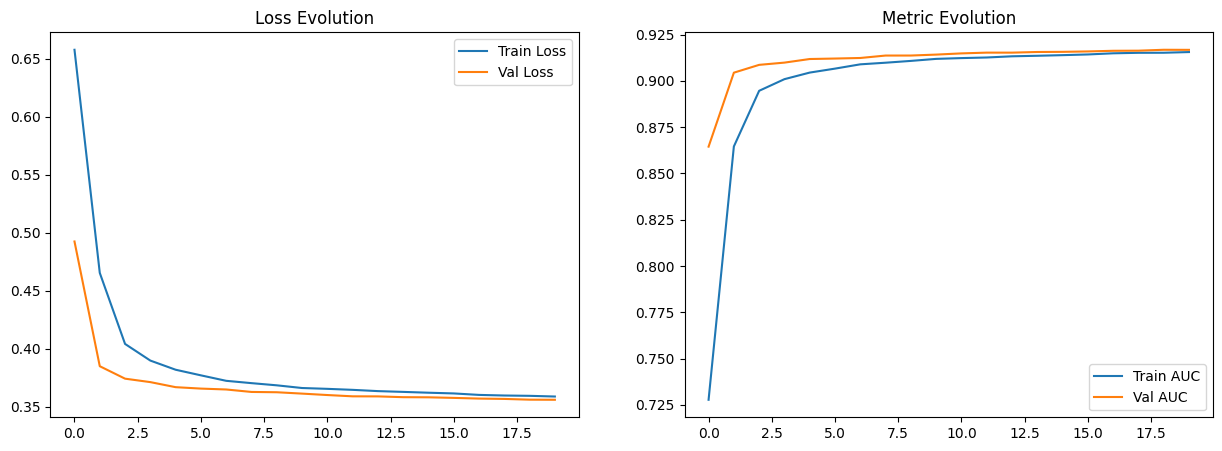

185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [34]:

model = Sequential([
    Dense(512, activation='relu', input_shape=(300,)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(y.shape[1], activation='sigmoid')
])

def lr_schedule(epoch):
    """Learning rate с warmup"""
    warmup = 5
    if epoch < warmup:
        return 0.001 * (epoch + 1) / warmup
    return 0.001 * (0.9 ** (epoch - warmup))

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

callbacks = [
    EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_auc', save_best_only=True, mode='max'),
    LearningRateScheduler(lr_schedule)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

def plot_training(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history['loss'], label='Train Loss')
    ax1.plot(history.history['val_loss'], label='Val Loss')
    ax1.set_title('Loss Evolution')
    ax1.legend()

    ax2.plot(history.history['auc'], label='Train AUC')
    ax2.plot(history.history['val_auc'], label='Val AUC')
    ax2.set_title('Metric Evolution')
    ax2.legend()

    plt.show()

plot_training(history)

best_model = tf.keras.models.load_model('best_model.h5')
val_pred = best_model.predict(X_val) > 0.5

In [35]:
df_test['clean_w2v'] = df_test['text'].apply(clean_text_w2v)
test_tokens = [text.split() for text in df_test['clean_w2v']]
X_test_w2v = np.array([text_to_vector(tokens, w2v_model) for tokens in test_tokens])
X_test_scaled = scaler.transform(X_test_w2v)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

In [36]:
test_tokens = [text.split() for text in df_test['clean_w2v']]
X_test_w2v = np.array([text_to_vector(tokens, w2v_model) for tokens in test_tokens])
X_test_scaled = scaler.transform(X_test_w2v)

In [37]:
best_model = tf.keras.models.load_model('best_model.h5')
test_pred_proba = best_model.predict(X_test_scaled)
test_pred = (test_pred_proba > 0.5).astype(int)

231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [39]:
test_labels = [' '.join(map(str, row)) for row in test_pred]
final_df = pd.DataFrame({
    'id': range(29568, 29568 + len(df_test)),
    'labels': test_labels
}).set_index('id')
final_df.to_csv('w2v_predictions.csv', index=True)

Результат:
---


0.68


BERT

In [40]:
BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 0.001
PATIENCE = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используется устройство: {DEVICE}")


Используется устройство: cpu


In [41]:
print(X_train)

[[-1.26290042 -1.8172945   0.47164678 ...  0.90596666  0.56328769
  -1.13076272]
 [ 0.70191074  0.86263578  0.32255715 ... -1.65239994 -0.34662657
   0.25964465]
 [-0.92511144 -0.63021411  1.00151965 ... -0.13541507  0.83847288
   0.61815132]
 ...
 [-0.98393868 -0.57710617 -0.07593605 ... -0.02793701  0.05665303
  -0.35631184]
 [ 0.01775541  0.20609289 -1.5246954  ... -0.46237716 -1.03511069
  -0.76678772]
 [-0.26978826 -0.06000346 -1.71654655 ... -0.2374004  -0.99710384
  -0.77692464]]


Epoch 1/20
  Train Loss: 0.3976
  Val Loss: 0.3733
  Val F1: 0.6764
Новая модель!
Epoch 2/20
  Train Loss: 0.3705
  Val Loss: 0.3678
  Val F1: 0.6807
Новая модель!
Epoch 3/20
  Train Loss: 0.3675
  Val Loss: 0.3661
  Val F1: 0.6777
Epoch 4/20
  Train Loss: 0.3642
  Val Loss: 0.3651
  Val F1: 0.6770
Epoch 5/20
  Train Loss: 0.3627
  Val Loss: 0.3623
  Val F1: 0.6809
Новая модель!
Epoch 6/20
  Train Loss: 0.3614
  Val Loss: 0.3611
  Val F1: 0.6773
Epoch 7/20
  Train Loss: 0.3604
  Val Loss: 0.3636
  Val F1: 0.6786
Epoch 8/20
  Train Loss: 0.3593
  Val Loss: 0.3582
  Val F1: 0.6803
   Early stopping after 3 epochs without improvement


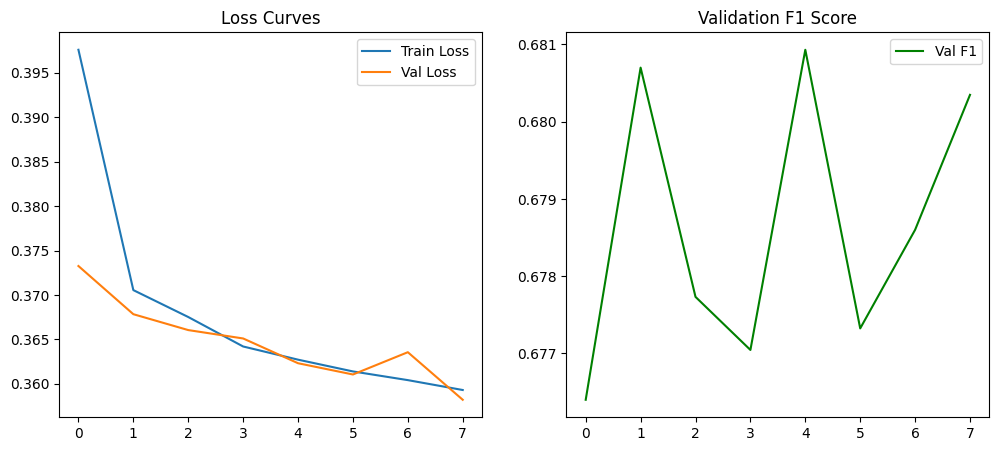

Лучшая модель загружена!


In [42]:
X_train = np.array(X_train, dtype=np.float32) if not isinstance(X_train, np.ndarray) else X_train.astype(np.float32)
X_val = np.array(X_val, dtype=np.float32) if not isinstance(X_val, np.ndarray) else X_val.astype(np.float32)
y_train = np.array(y_train, dtype=np.float32) if not isinstance(y_train, np.ndarray) else y_train.astype(np.float32)
y_val = np.array(y_val, dtype=np.float32) if not isinstance(y_val, np.ndarray) else y_val.astype(np.float32)

class VectorDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return {
            'features': self.features[idx],
            'labels': self.labels[idx]
        }

train_dataset = VectorDataset(X_train, y_train)
val_dataset = VectorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


class DenseClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128, output_size)
        )

    def forward(self, x):
        if isinstance(x, dict):  # Если вход из DataLoader
            return self.net(x['features'])
        return self.net(x)  # Если прямой вызов

model = DenseClassifier(input_size=X_train.shape[1],
                       output_size=y_train.shape[1]).to(DEVICE)


criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)


train_losses = []
val_losses = []
val_f1s = []
best_f1 = 0
early_stop_counter = 0

for epoch in range(EPOCHS):

    model.train()
    epoch_train_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()
        outputs = model(batch)
        loss = criterion(outputs, batch['labels'].to(DEVICE))
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    epoch_val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            outputs = model(batch)
            loss = criterion(outputs, batch['labels'].to(DEVICE))
            epoch_val_loss += loss.item()

            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(batch['labels'].cpu().numpy())

    val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(val_loss)

    preds = np.vstack(all_preds) > 0.5
    labels = np.vstack(all_labels)
    val_f1 = f1_score(labels, preds, average='macro')
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  Val F1: {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), "best_model.pth")
        early_stop_counter = 0
        print("Новая модель!")
    else:
        early_stop_counter += 1
        if early_stop_counter >= PATIENCE:
            print(f"   Early stopping after {PATIENCE} epochs without improvement")
            break

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_f1s, label='Val F1', color='green')
plt.title('Validation F1 Score')
plt.legend()
plt.show()

model.load_state_dict(torch.load("best_model.pth"))
print("Лучшая модель загружена!")


In [43]:

X_test_tfidf = X_test_tfidf[:, :300]

class TestDataset(Dataset):
    def __init__(self, features):
        self.features = torch.tensor(features.toarray(), dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return {'features': self.features[idx]}

test_dataset = TestDataset(X_test_tfidf)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = DenseClassifier(input_size=300,  # Размерность тренировочных данных
                       output_size=y_train.shape[1]).to(DEVICE)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()


all_preds = []
with torch.no_grad():
    for batch in test_loader:
        outputs = model(batch)
        preds = torch.sigmoid(outputs).cpu().numpy()
        all_preds.append(preds)

test_preds = np.vstack(all_preds)


ids = list(range(29568, 29568 + len(df_test)))
labels_str = [' '.join(map(str, (row > 0.5).astype(int))) for row in test_preds]

pd.DataFrame({'id': ids, 'labels': labels_str}) \
  .set_index('id') \
  .to_csv('predictions.csv')

print(" Предсказания сохранены в predictions.csv")

 Предсказания сохранены в predictions.csv


# Генератор

In [54]:
from tqdm import tqdm

In [44]:
label_counts = pd.DataFrame(y_train).sum(axis=0)
label_probs = label_counts / label_counts.sum()
print("Распределение меток в исходных данных:")
print(label_probs)

Распределение меток в исходных данных:
0     0.049878
1     0.060690
2     0.004750
3     0.005682
4     0.056784
5     0.000332
6     0.000632
7     0.072102
8     0.074763
9     0.065820
10    0.041171
11    0.059317
12    0.073755
13    0.073486
14    0.071490
15    0.047537
16    0.070093
17    0.075467
18    0.077920
19    0.018331
dtype: float32


In [45]:
label_counts = pd.DataFrame(y_train).sum(axis=0)
label_probs = label_counts / label_counts.sum()
print("Распределение меток в исходных данных:")
print(label_probs)

Распределение меток в исходных данных:
0     0.049878
1     0.060690
2     0.004750
3     0.005682
4     0.056784
5     0.000332
6     0.000632
7     0.072102
8     0.074763
9     0.065820
10    0.041171
11    0.059317
12    0.073755
13    0.073486
14    0.071490
15    0.047537
16    0.070093
17    0.075467
18    0.077920
19    0.018331
dtype: float32


In [63]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "sberbank-ai/rugpt3small_based_on_gpt2"

tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name).to(device)
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50264, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50264, bias=False)
)

In [64]:

def generate_text_batch(prompt, max_length=100, num_return_sequences=10):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(
        **inputs,
        max_length=max_length,
        do_sample=True,
        top_p=0.9,
        top_k=50,
        temperature=0.7,
        no_repeat_ngram_size=3,
        num_return_sequences=num_return_sequences,
        pad_token_id=tokenizer.eos_token_id,
        early_stopping=True
    )
    return [tokenizer.decode(o, skip_special_tokens=True) for o in outputs]

total_to_generate = 1000
batch_size = 10
label_probs = y_train.mean(axis=0)

generated_data = []
for _ in tqdm(range(total_to_generate // batch_size), desc="Генерация данных"):

    batch_labels = (np.random.rand(batch_size, len(label_probs)) < label_probs).astype(int)

    for labels in batch_labels:

        prompt = f"Текст с метками {' '.join(map(str, labels))}: "


        try:
            text = generate_text_batch(prompt, num_return_sequences=1)[0]
            generated_data.append({
                'text': text.replace(prompt, "").strip(),
                'labels': labels.tolist()
            })
        except Exception as e:
            print(f"Ошибка генерации: {str(e)}")

Генерация данных:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:679: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
Генерация данных: 100%|██████████| 100/100 [1:25:30<00:00, 51.30s/it]


In [66]:
synth_df = pd.DataFrame(generated_data)
print(f"\nУспешно сгенерировано {len(synth_df)} примеров")


Успешно сгенерировано 1000 примеров


In [73]:
enriched_df = pd.concat([df, synth_df], ignore_index=True)
enriched_df


,id,text,labels,labels_list,clean_tfidf,clean_w2v,clean_minimal,tokens
0,0.0,15 января\nДетская развлекательная программа\n...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1,"[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, ...",январь детский развлекательный программа беспл...,январь детский развлекательный программа беспл...,"[1, 5, я, н, в, а, р, я, д, е, т, с, к, а, я, ...","[январь, детский, развлекательный, программа, ..."
1,1.0,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1,"[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, ...",август выходной мег мегапарк,и август выходной в мег мегапарк,"[1, 3, и, 1, 4, а, в, г, у, с, т, а, в, ы, х, ...","[и, август, выходной, в, мег, мегапарк]"
2,2.0,Йокнапатофа\nПостановка Театр им. Маяковского\...,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...",йокнапатоф постановка театр маяковский билет р,йокнапатоф постановка театр они маяковский бил...,"[й, о, к, н, а, п, а, т, о, ф, а, п, о, с, т, ...","[йокнапатоф, постановка, театр, они, маяковски..."
3,3.0,Впервые в Уфе танцевальная терапия в группе с ...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...",впервые уфа танцевальный терапия группа практи...,впервые в уфа танцевальный терапия в группа с ...,"[в, п, е, р, в, ы, е, в, у, ф, е, т, а, н, ц, ...","[впервые, в, уфа, танцевальный, терапия, в, гр..."
4,4.0,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0,"[1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, ...",друг сегодня открытие международный конкурс пи...,друг сегодня открытие международный конкурс дл...,"[🎹, g, r, a, n, d, p, i, a, n, o, c, o, m, p, ...","[друг, сегодня, открытие, международный, конку..."
...,...,...,...,...,...,...,...,...
30563,NaN,1.1.3.3-1.6.2.3\n1-1 2-1 3-1 4-1 5-1 6-1 7-1 8...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, ...",NaN,NaN,NaN,NaN,NaN
30564,NaN,\t\t\n\ts\n\textarea\n\tt\n\xc2\n\ti\n\bm\n\c2...,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, ...",NaN,NaN,NaN,NaN,NaN
30565,NaN,___ __ __# __ # __ # _# _ _ # # __ # __...,"[0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, ...",NaN,NaN,NaN,NaN,NaN
30566,NaN,1.\n&lt;br&gt; &lt;/br&nbsp;\n2.\n\n&nbsp;&nb...,"[0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, ...",NaN,NaN,NaN,NaN,NaN


Для kaggle

In [ ]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [ ]:
import inspect
def getargspec(func):
    """Реализация getargspec для новых версий Python"""
    sig = inspect.signature(func)
    args = []
    varargs = None
    varkw = None
    defaults = []

    for param in sig.parameters.values():
        if param.kind == param.VAR_POSITIONAL:
            varargs = param.name
        elif param.kind == param.VAR_KEYWORD:
            varkw = param.name
        else:
            args.append(param.name)
            if param.default is not param.empty:
                defaults.append(param.default)

    return collections.namedtuple('ArgSpec', 'args varargs keywords defaults')(
        args, varargs, varkw, tuple(defaults) if defaults else None)

if not hasattr(inspect, 'getargspec'):
    inspect.getargspec = getargspec

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))
morph = MorphAnalyzer()

In [ ]:
def clean_text_tfidf(text):
    text = text.lower()
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'[^а-яё\s]', '', text)
    words = text.split()
    words = [morph.parse(w)[0].normal_form for w in words if w not in stop_words]
    return ' '.join(words)

In [ ]:
X = df['clean_tfidf'].tolist()
y = np.array(list(df['labels_list']), dtype=np.float32)
tfidf = TfidfVectorizer(max_features=10000)
X_tfidf = tfidf.fit_transform(X)
X_train, X_val, y_train, y_val = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42)
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return (
            torch.FloatTensor(self.X[idx].toarray().squeeze()),
            torch.FloatTensor(self.y[idx])
        )

train_loader = DataLoader(TextDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TextDataset(X_val, y_val), batch_size=64)
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

model = MLP(X_train.shape[1], y_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate(model, loader, criterion, threshold=0.5):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch)
            all_preds.append(outputs.numpy())
            all_labels.append(y_batch.numpy())

    preds = (np.concatenate(all_preds) > threshold).astype(int)
    labels = np.concatenate(all_labels)
    return f1_score(labels, preds, average='micro')
epochs = 20
train_losses = []
val_scores = []

for epoch in range(epochs):
    loss = train_epoch(model, train_loader, optimizer, criterion)
    score = validate(model, val_loader, criterion)

    train_losses.append(loss)
    val_scores.append(score)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {loss:.4f} | Val F1: {score:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
df_test = pd.read_csv('test.csv')
df_test['clean_tfidf'] = df_test['text'].apply(clean_text_tfidf)
X_test_tfidf = tfidf.transform(df_test['clean_tfidf'])
X_test_tensor = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)
model.eval()

with torch.no_grad():
    preds_proba = model(X_test_tensor).cpu().numpy()

threshold = 0.5
y_test_pred = (preds_proba > threshold).astype(int)
ids = list(range(29568, 29568 + len(df_test)))

labels_str = [' '.join(map(str, row)) for row in y_test_pred]

final_dataframe = pd.DataFrame({
    'id': ids,
    'labels': labels_str
}).set_index('id')

final_dataframe.to_csv('predictions.csv', index=True)
print("Результаты сохранены в predictions.csv")